# L-DED Audiovisual Fusion 

Author: Chen Lequn.
Created on 01 Feb 2023.

- Material： Maraging Steel 300
- Process: Robotic Llser-directed energy deposition
- Experiment number (single bead wall samples): 21-26
- Recorded data: position, veolocity, coaxial melt pool images, acoustic data
- Defect generated: keyhole pores, cracks, defect-free

### Notebook 2: benchmarking on coaxial vision dataset

- Performances for various deep learning models (VGG, GoogleNet, ResNet, LeNet, etc.) are evaluated and benchmarked on the coaxial melt pool image dataset.
- Best performance will guide subsequent multimodal fusion network development.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torch.backends.cudnn as cudnn

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, random_split, SubsetRandomSampler, WeightedRandomSampler

import os
import argparse
from torch.utils.data import Subset
import pandas as pd
import numpy as np

# Scikit learn
#from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle, resample, class_weight
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, KFold
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split, StratifiedShuffleSplit

from vision_models import * 
from multimodaldataset import MultimodalDataset, LDEDAudioDataset, LDEDVisionDataset
from utils import *
from train_utils import train_single_epoch, test_single_epoch, training_loop

## plot
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
# plt.rcParams["font.family"] = "serif"
# plt.rcParams["font.serif"] = "Times New Roman"
%matplotlib inline
import seaborn as sns

np.random.seed(0)
# torch.manual_seed(0)

In [2]:
# torch.cuda.empty_cache()

### Utils functions

In [3]:
PROJECT_ROOT_DIR = "../"
IMAGE_PATH = os.path.join(PROJECT_ROOT_DIR, "result_images", 'defect classification', 'class_name_v3','train_visual')
os.makedirs(IMAGE_PATH, exist_ok=True)

model_path = os.path.join(PROJECT_ROOT_DIR, "trained_models", 'defect classification', 'class_name_v3', 'visual_model')

Multimodal_dataset_PATH = "/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset"
Dataset_path = os.path.join(Multimodal_dataset_PATH, f'25Hz')

## function for automatically save the diagram/graph into the folder 
def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGE_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

plt.rcParams["axes.edgecolor"] = "black"
plt.rcParams["axes.linewidth"] = 2.50

In [4]:
# classes = ('Defect-free', 'Defective', 'Laser-off')
# classes = ('Laser-off', 'Defect-free', 'Cracks', "Keyhole pores")
classes = ('Defect-free', 'Keyhole pores', 'Laser defocus', 'Laser-off')

SAMPLE_RATE = 44100
LEARNING_RATE = 0.00001
BATCH_SIZE = 32
EPOCHS = 20

### Use GPU if possible

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device}")

Using cuda


### Annotation file

- Vision acoustic spatio-temporal registration has been done in our previous work. 
- Each frame (timestamp) corresponds to a robot TCP position.
- The duration for each frame is 0.033 seconds (sampling freqeuncy 30 Hz.)

In [6]:
# Read the data back from the HDF5 file into a new DataFrame
df_multimodal = pd.read_hdf(os.path.join(Dataset_path, 'spatiotemporal_fused_multimodal.h5'), key='df')
df_multimodal = df_multimodal.dropna(subset=['class_name_v3'])

# Fill NaN values in 'class_name' with 'Unlabeled'
# df_multimodal['class_name'] = df_multimodal['class_name'].astype(str)
# df_multimodal['class_name'].fillna('Unlabeled', inplace=True)
df_multimodal

,sample index,Time_Stamps,audio_file_name,image_file_name,class_name,class_name_v2,Layer number,Sample number,class_name_v3,rms_energy,...,center_y,contour_area,contour_length,X,Y,Z,Vx,Vy,Vz,Speed
0,1,0.00,sample_21_1.wav,sample_21_1.jpg,Laser-off,Laser-off,1.0,21,Laser-off,0.009018,...,0.000000,0.0,0.000000,0.000,0.000,0.000,0.000,-0.000,0.000,0.000
1,2,0.04,sample_21_2.wav,sample_21_2.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.019286,...,239.000000,305442.0,2234.000000,0.000,-0.000,0.001,-0.074,-0.074,0.000,0.105
2,3,0.08,sample_21_3.wav,sample_21_3.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.019593,...,239.000000,305442.0,2234.000000,-0.010,0.015,-0.007,-0.051,0.026,-0.051,0.077
3,4,0.12,sample_21_4.wav,sample_21_4.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.030937,...,230.264496,291865.5,2279.781744,-0.007,0.016,0.010,0.173,-0.222,2.520,2.536
4,5,0.16,sample_21_5.wav,sample_21_5.jpg,Defect-free,Defect-free,1.0,21,Defect-free,0.038329,...,229.109962,281970.0,2407.847760,-0.111,0.123,-0.057,-1.864,1.662,-2.468,3.511
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48461,10982,439.24,sample_26_10982.wav,sample_26_10982.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.011000,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48462,10983,439.28,sample_26_10983.wav,sample_26_10983.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.008347,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48463,10984,439.32,sample_26_10984.wav,sample_26_10984.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.011081,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080
48464,10985,439.36,sample_26_10985.wav,sample_26_10985.jpg,Laser-off,Laser-off,NaN,26,Laser-off,0.011044,...,0.000000,0.0,0.000000,0.000,0.000,0.000,-0.076,0.025,0.000,0.080


In [7]:
def get_sample_directories_from_df(df, Dataset_path):
    # Extract unique sample numbers from the DataFrame
    unique_sample_numbers = df['Sample number'].unique()
    
    # Generate the full paths for image and audio directories
    image_directories = [os.path.join(Dataset_path, str(sample_number), 'images') for sample_number in unique_sample_numbers]
    audio_directories = [os.path.join(Dataset_path, str(sample_number), 'raw_audio') for sample_number in unique_sample_numbers]
    
    return image_directories, audio_directories

samples = [21, 22, 23, 26]
image_directories, audio_directories = get_sample_directories_from_df(df_multimodal, Dataset_path)

In [8]:
image_directories

['/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/21/images',
 '/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/22/images',
 '/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/23/images',
 '/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/24/images',
 '/home/chenlequn/pan1/Dataset/LDED_acoustic_visual_monitoring_dataset/25Hz/26/images']

In [9]:
# Get the labels and count the number of samples for each class
labels = df_multimodal['class_name_v3'].values
label_counts = np.unique(labels, return_counts=True)[1]
print (label_counts)

[ 7601  4991  6208 17757]


### Basline accuracy
The baseline accuracy in this multi-class classificiation problem is **55%**, which is the accuracy of trivially predicting the most-frequent class (classify to the largest class– in other words).

In [10]:
### Get the percentage distribution of each category
round(df_multimodal.groupby('class_name_v3')["class_name_v3"].count()/df_multimodal.shape[0]*100, 1)

class_name_v3
Defect-free      20.8
Keyhole pores    13.7
Laser defocus    17.0
Laser-off        48.6
Name: class_name_v3, dtype: float64

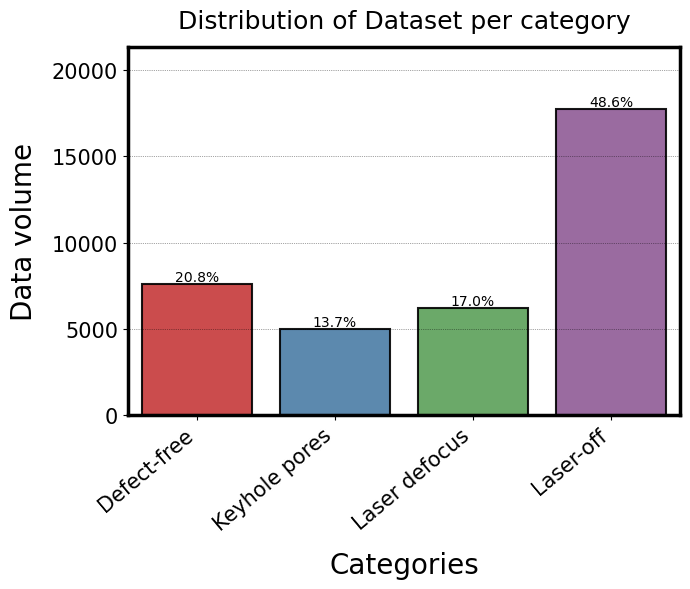

In [11]:
plot_data_distribution(df_multimodal, 'class_name_v3', 
                       'Distribution of Dataset per category', 'dataset_distribution')

## Preparing Dataset and DataLoader

Mean: 76.93087324120341

Standard Deviation: 71.49791275013504

In [12]:
#------ transformation------
train_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.RandomHorizontalFlip(),  # data augmentation
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=90),
    transforms.ToTensor(),
    transforms.Normalize(mean=[76.93087324120341], std=[71.49791275013504]),
])

val_transforms=transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[76.93087324120341], std=[71.49791275013504]),
])

In [13]:
#------ data loader------
# create the dataset for all samples
visiondataset = LDEDVisionDataset(df_multimodal,
                                  image_directories,
                                  samples,
                                  train_transforms,
                                  device)
print ("length of the total dataset:" + str(len(visiondataset)))

length of the total dataset:36557


## Train Val Test dataset 

In [14]:
%store -r train_indices
%store -r val_indices
%store -r test_indices

In [15]:
# Create train, val, and test datasets for deep learning models
train_annotations = df_multimodal.iloc[train_indices, :]
val_annotations = df_multimodal.iloc[val_indices, :]
test_annotations = df_multimodal.iloc[test_indices, :]

train_dataset = LDEDVisionDataset(train_annotations, image_directories, samples, train_transforms, device=device)
val_dataset = LDEDVisionDataset(val_annotations, image_directories, samples, val_transforms, device=device)
test_dataset = LDEDVisionDataset(test_annotations, image_directories, samples, val_transforms, device=device)

### Create DataLoader using the dataset

In [16]:
# # Create train and val dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

print("length of the train dataset:" +  str(len(train_dataloader.dataset)))
print("length of the val dataset:" +  str(len(val_dataloader.dataset)))
print("length of the test dataset:" +  str(len(test_dataloader.dataset)))

length of the train dataset:3476
length of the val dataset:434
length of the test dataset:435


## Training the model

In [17]:
resume = False
start_epoch = 0
best_acc = 0

In [18]:
# -----Model---------------
print('==> Building model..')
net = VGG('VGG19')
# net = LeNet() 
# net = ResNet18()
# net = PreActResNet18()
# net = GoogLeNet()
# net = DenseNet121()
# net = ResNeXt29_2x64d()
# net = MobileNet()
# net = MobileNetV2()
# net = DPN92()
# net = ShuffleNetG2()
# net = SENet18()
# net = ShuffleNetV2(1)
# net = EfficientNetB0()
# net = RegNetX_200MF()
# net = SimpleDLA()
net = net.to(device)
if device == 'cuda':
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True
    print ("--- Using CUDA ---")

if resume:
    # Load checkpoint.
    print('==> Resuming from checkpoint..')
    assert os.path.isdir('checkpoint'), 'Error: no checkpoint directory found!'
    checkpoint = torch.load('./checkpoint/ckpt.pth')
    net.load_state_dict(checkpoint['net'])
    best_acc = checkpoint['acc']
    start_epoch = checkpoint['epoch']

loss_fn = nn.CrossEntropyLoss()
# Note: weight_decay in pytorch is L2 regularization
# optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATE,
#                     momentum=0.9, weight_decay=5e-4)
optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)


# for epoch in range(start_epoch, start_epoch+EPOCHS):
#     train_single_epoch(net, epoch, train_dataloader, loss_fn, optimizer, device)
#     test_single_epoch(net, epoch, val_dataloader, loss_fn, device)
#     scheduler.step()

# model, optimizer, _ = training_loop(net, loss_fn, optimizer, train_dataloader, val_dataloader, EPOCHS, scheduler, device)
model, optimizer, (train_losses, valid_losses, train_accuracy, valid_accuracy) = training_loop(net, loss_fn, optimizer, train_dataloader, 
                                                                                               val_dataloader, EPOCHS, scheduler, device)

==> Building model..
--- Using CUDA ---

Epoch: 0


Epoch 0:   0%|                                                        | 0/14 [00:00<?, ?it/s, loss=1.11, accuracy=49.8]


15:10:16 --- Epoch: 0	Train loss: 0.6521	Valid loss: 0.0357	Train accuracy: 73.82	Valid accuracy: 49.77

Epoch: 1


Epoch 1:   0%|                                                       | 0/14 [00:00<?, ?it/s, loss=0.726, accuracy=58.1]


15:10:19 --- Epoch: 1	Train loss: 0.4533	Valid loss: 0.0234	Train accuracy: 82.45	Valid accuracy: 58.06

Epoch: 2


Epoch 2:   0%|                                                       | 0/14 [00:00<?, ?it/s, loss=0.522, accuracy=84.3]


15:10:21 --- Epoch: 2	Train loss: 0.4232	Valid loss: 0.0168	Train accuracy: 83.00	Valid accuracy: 84.33

Epoch: 3


Epoch 3:   0%|                                                       | 0/14 [00:00<?, ?it/s, loss=0.642, accuracy=81.1]


15:10:23 --- Epoch: 3	Train loss: 0.4099	Valid loss: 0.0207	Train accuracy: 84.06	Valid accuracy: 81.11

Epoch: 4


Epoch 4:   0%|                                                       | 0/14 [00:00<?, ?it/s, loss=0.758, accuracy=68.9]


15:10:25 --- Epoch: 4	Train loss: 0.3742	Valid loss: 0.0245	Train accuracy: 84.93	Valid accuracy: 68.89

Epoch: 5


Epoch 5:   0%|                                                       | 0/14 [00:00<?, ?it/s, loss=0.409, accuracy=87.3]


15:10:28 --- Epoch: 5	Train loss: 0.3687	Valid loss: 0.0132	Train accuracy: 85.67	Valid accuracy: 87.33

Epoch: 6


Epoch 6:   0%|                                                       | 0/14 [00:00<?, ?it/s, loss=0.299, accuracy=87.6]


15:10:30 --- Epoch: 6	Train loss: 0.3654	Valid loss: 0.0097	Train accuracy: 85.76	Valid accuracy: 87.56

Epoch: 7


Epoch 7:   0%|                                                        | 0/14 [00:00<?, ?it/s, loss=0.36, accuracy=84.6]


15:10:32 --- Epoch: 7	Train loss: 0.3449	Valid loss: 0.0116	Train accuracy: 87.26	Valid accuracy: 84.56

Epoch: 8


Epoch 8:   0%|                                                        | 0/14 [00:00<?, ?it/s, loss=1.94, accuracy=63.8]


15:10:35 --- Epoch: 8	Train loss: 0.3593	Valid loss: 0.0624	Train accuracy: 86.13	Valid accuracy: 63.82

Epoch: 9


Epoch 9:   0%|                                                        | 0/14 [00:00<?, ?it/s, loss=0.36, accuracy=86.6]


15:10:37 --- Epoch: 9	Train loss: 0.3358	Valid loss: 0.0116	Train accuracy: 88.29	Valid accuracy: 86.64

Epoch: 10


Epoch 10:   0%|                                                      | 0/14 [00:00<?, ?it/s, loss=0.829, accuracy=66.4]


15:10:39 --- Epoch: 10	Train loss: 0.3295	Valid loss: 0.0267	Train accuracy: 87.46	Valid accuracy: 66.36

Epoch: 11


Epoch 11:   0%|                                                      | 0/14 [00:00<?, ?it/s, loss=0.599, accuracy=73.3]


15:10:41 --- Epoch: 11	Train loss: 0.3249	Valid loss: 0.0193	Train accuracy: 87.26	Valid accuracy: 73.27

Epoch: 12


Epoch 12:   0%|                                                      | 0/14 [00:00<?, ?it/s, loss=0.292, accuracy=88.7]


15:10:44 --- Epoch: 12	Train loss: 0.3022	Valid loss: 0.0094	Train accuracy: 88.32	Valid accuracy: 88.71

Epoch: 13


Epoch 13:   0%|                                                        | 0/14 [00:00<?, ?it/s, loss=0.372, accuracy=88]


15:10:46 --- Epoch: 13	Train loss: 0.3020	Valid loss: 0.0120	Train accuracy: 88.78	Valid accuracy: 88.02

Epoch: 14


Epoch 14:   0%|                                                       | 0/14 [00:00<?, ?it/s, loss=1.24, accuracy=66.6]


15:10:48 --- Epoch: 14	Train loss: 0.2868	Valid loss: 0.0398	Train accuracy: 88.69	Valid accuracy: 66.59

Epoch: 15


Epoch 15:   0%|                                                      | 0/14 [00:00<?, ?it/s, loss=0.358, accuracy=86.4]


15:10:50 --- Epoch: 15	Train loss: 0.2974	Valid loss: 0.0115	Train accuracy: 88.15	Valid accuracy: 86.41

Epoch: 16


Epoch 16:   0%|                                                      | 0/14 [00:00<?, ?it/s, loss=0.299, accuracy=88.7]


15:10:53 --- Epoch: 16	Train loss: 0.2886	Valid loss: 0.0096	Train accuracy: 88.58	Valid accuracy: 88.71

Epoch: 17


Epoch 17:   0%|                                                       | 0/14 [00:00<?, ?it/s, loss=0.93, accuracy=70.7]


15:10:55 --- Epoch: 17	Train loss: 0.2877	Valid loss: 0.0300	Train accuracy: 88.90	Valid accuracy: 70.74

Epoch: 18


Epoch 18:   0%|                                                       | 0/14 [00:00<?, ?it/s, loss=2.67, accuracy=40.8]


15:10:57 --- Epoch: 18	Train loss: 0.2844	Valid loss: 0.0862	Train accuracy: 89.21	Valid accuracy: 40.78

Epoch: 19


Epoch 19:   0%|                                                      | 0/14 [00:00<?, ?it/s, loss=0.297, accuracy=90.1]

15:11:00 --- Epoch: 19	Train loss: 0.2803	Valid loss: 0.0096	Train accuracy: 89.21	Valid accuracy: 90.09


In [19]:
valid_accuracy

[49.76958525345622,
 58.064516129032256,
 84.33179723502305,
 81.10599078341014,
 68.89400921658986,
 87.32718894009217,
 87.55760368663594,
 84.56221198156682,
 63.824884792626726,
 86.63594470046083,
 66.3594470046083,
 73.27188940092167,
 88.70967741935483,
 88.0184331797235,
 66.58986175115207,
 86.40552995391705,
 88.70967741935483,
 70.73732718894009,
 40.78341013824885,
 90.09216589861751]

Saving figure train_lost_curve_visual


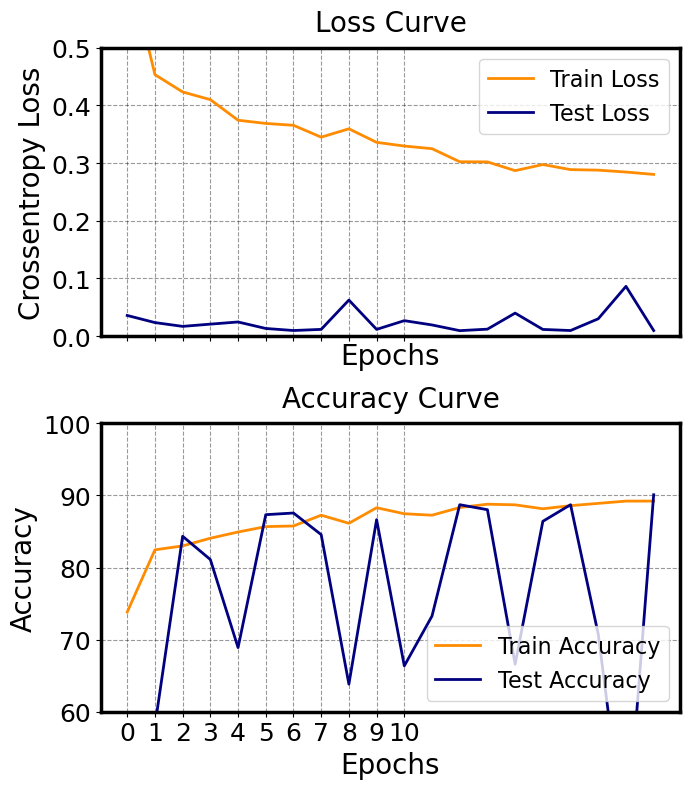

In [20]:
loss_acc_plot(train_losses, valid_losses, train_accuracy, valid_accuracy, 10, "Initial Training",
              interval=1, yloss_limit1=0, yloss_limit2=0.50, yacc_limit1=60, yacc_limit2=100)

save_fig ("train_lost_curve_visual")

In [21]:
get_accuracy(model, val_dataloader, device)

0.9009216589861752

Test Accuracy (cross-validation) for visual_VGG16 = 0.86897 ± 0.03050
micro-averaging AUC for visual_VGG16 = 0.96988 ± 0.00000
Saving figure ROC_curve (vision-based)


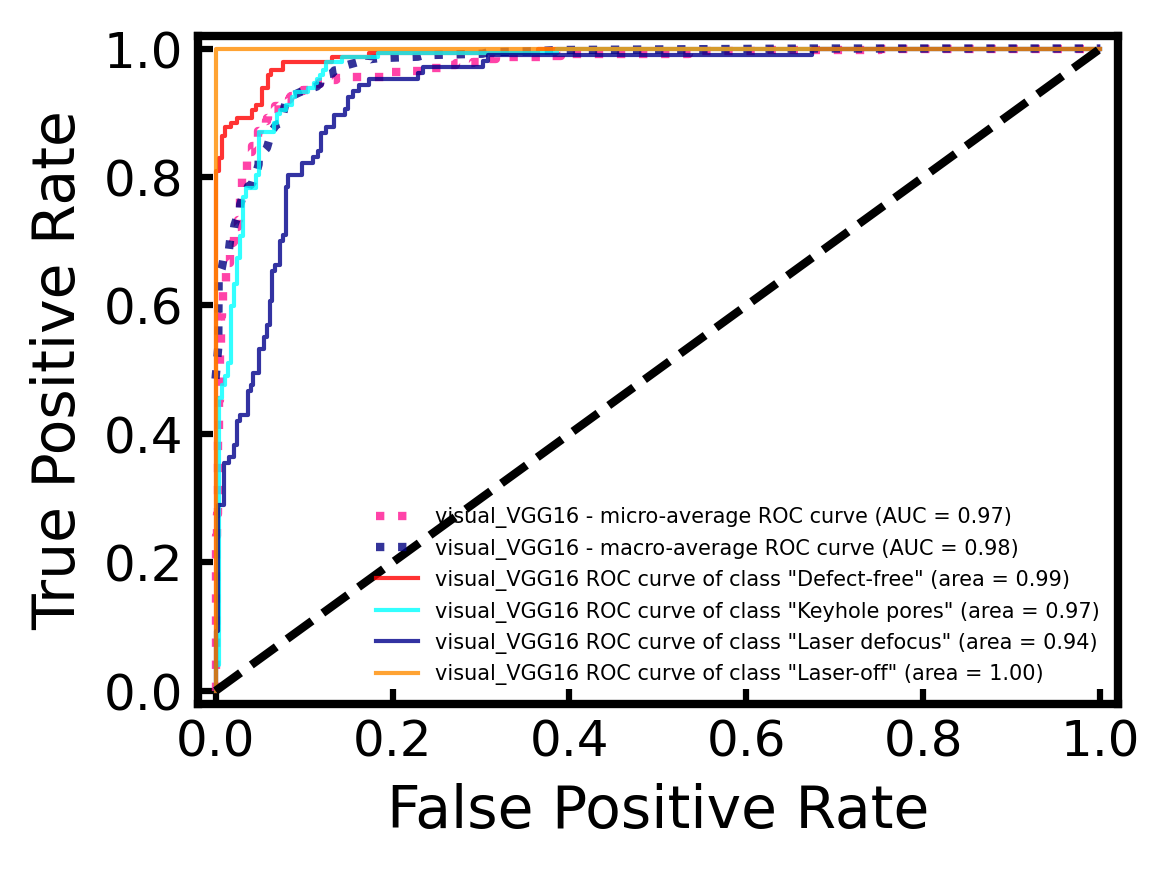

In [22]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std = model_evaluation(model, test_dataloader, classes, device, classifier_name = "visual_VGG16", 
                                                                            signal_type = "raw", seed=0)

save_fig ("ROC_curve (vision-based)")

In [23]:
test_accuracy_mean, test_accuracy_std, auc_mean, auc_std

(0.8689655172413794, 0.03049769922165886, 0.969882415114282, 0.0)

In [24]:
yt, yp = class_report(model, test_dataloader, device, classes)

               precision    recall  f1-score   support

  Defect-free     1.0000    0.8231    0.9030       147
Keyhole pores     0.8684    0.8980    0.8829       147
Laser defocus     0.7165    0.8505    0.7778       107
    Laser-off     0.9714    1.0000    0.9855        34

     accuracy                         0.8690       435
    macro avg     0.8891    0.8929    0.8873       435
 weighted avg     0.8836    0.8690    0.8719       435



In [25]:
def conf_matrix(y_true, y_pred, classes):
    cm = confusion_matrix(y_true, y_pred, labels=classes)
    
    # convert to percentage and plot the confusion matrix
    cm_pct = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    print(cm)
    plot_confusion_matrix(cm_pct, classes)

[[121   4  22   0]
 [  0 132  14   1]
 [  0  16  91   0]
 [  0   0   0  34]]
Saving figure confusion_matrix(vision_based)


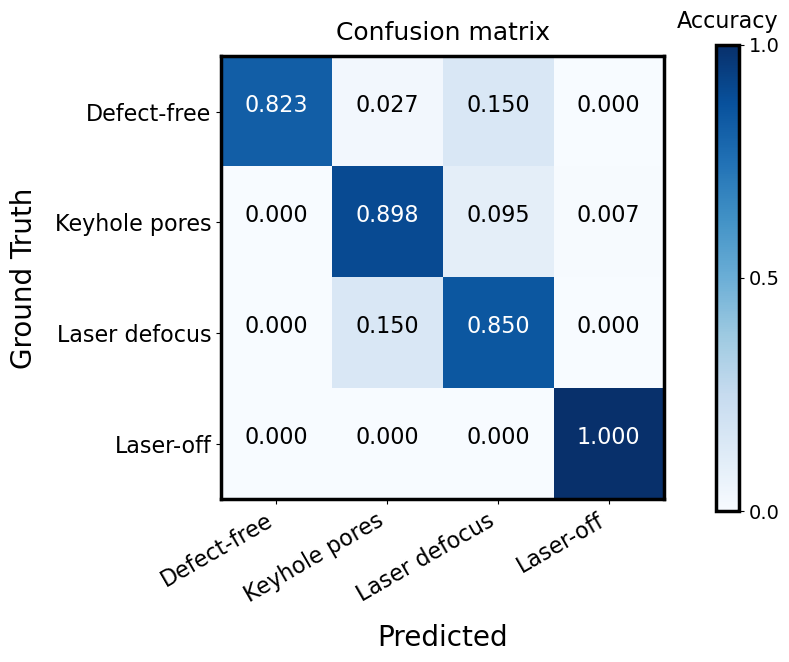

In [26]:
conf_matrix(yt, yp, classes)
save_fig("confusion_matrix(vision_based)")

### Save the trained model into the folder

In [27]:
# Save the model's state_dict
torch.save(model.state_dict(), os.path.join(model_path, 'trained_visual_VGG16.pth'))

RuntimeError: Parent directory ../trained_models/defect classification/class_name_v3/visual_model does not exist.

# Load the trained model to test

In [ ]:
# Initialize your model
model = nn.DataParallel(VGG('VGG19'))
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Load the state dictionary
model.load_state_dict(torch.load(os.path.join(model_path, 'trained_visual_VGG19.pth')))


model.eval()  # Set the model to evaluation mode

#### Random testing

In [ ]:
import PIL.Image

# Define the image transformation
transform = transforms.Compose([
    torchvision.transforms.Resize((32,32)), # original image size: (640,480)
    transforms.ToTensor(),
    transforms.Normalize(mean=[76.93087324120341], std=[71.49791275013504]),
])

# Load and preprocess the image
sample_number = 21
index = 1203
img_path = os.path.join(Dataset_path, f"{sample_number}/images/sample_{sample_number}_{index}.jpg")
input_image = PIL.Image.open(img_path).convert('L')  
input_tensor = transform(input_image)
input_batch = input_tensor.unsqueeze(0)  # Create a mini-batch as expected by the model

# Move the input to the GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_batch = input_batch.to(device)

# Make the prediction
with torch.no_grad():
    output = model(input_batch)

# The output has unnormalized scores. To get the label, we can use argmax to get the index of the maximum score
_, predicted_label_index = torch.max(output, 1)

print(f"Predicted label index: {predicted_label_index.item()}")


# (1) Map the predicted index to the actual class name
index_to_class = {
    0: 'Laser-off',
    1: 'Defect-free',
    2: 'Defective'
}

predicted_class_name = index_to_class[predicted_label_index.item()]
print(f"Predicted class name: {predicted_class_name}")

# (2) Display the image and print the ground truth label
try:
    ground_truth_label = df_multimodal.loc[
        (df_multimodal['Sample number'] == sample_number) & 
        (df_multimodal['image_file_name'] == f"sample_{sample_number}_{index}.jpg"), 
        'class_name_v2'
    ].iloc[0]
except IndexError:
    ground_truth_label = "NaN"


# Display the image
plt.imshow(input_image, cmap='gray')
plt.title(f"Ground Truth: {ground_truth_label}, Prediction: {predicted_class_name}")
plt.axis('off')
plt.show()